# Necessary packages and imports

In [1]:
# source: https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 19.9 MB/s eta 0:00:00


In [14]:
from transformers import TextDataset, DataCollatorForLanguageModeling, GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, set_seed
from peft import LoraConfig, get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import numpy as np
import bitsandbytes as bnb
import transformers
import matplotlib.pyplot as plt
import peft

# Model initializiation

In [23]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)

Freezing the model parameters to prepare for prompt tuning

In [7]:
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.lm_head = CastOutputToFloat(model.lm_head)

Loading and preparing the data

In [19]:
data = []
with open("parsed_quotes_context.txt", encoding='utf8') as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} -> {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [24]:
prompt_tuning_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="You will receive a text prompt followed by `->:` to which you should respond in Sherlock-style.",
    tokenizer_name_or_path='gpt2',
)

model = get_peft_model(model, prompt_tuning_config)

trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

trainable params: 15360 || all params: 124455168 || trainable%: 0.012341793632868666


In [11]:
tokenizer.pad_token = tokenizer.eos_token

# Training the model
Seeding the model so that results are reproducible

In [20]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [25]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
trainer.train()

Step,Training Loss,Validation Loss
20,4.653100,4.208174
40,4.684500,4.184707
60,4.409000,4.147604
80,4.476900,4.104209
100,4.378800,4.054977
120,4.391500,4.016617
140,4.212100,3.991290
160,4.143700,3.969008
180,4.406100,3.949093
200,4.232900,3.928972


TrainOutput(global_step=1000, training_loss=4.098797860145569, metrics={'train_runtime': 255.6274, 'train_samples_per_second': 62.591, 'train_steps_per_second': 3.912, 'total_flos': 640022584320000.0, 'train_loss': 4.098797860145569, 'epoch': 23.39})

# Inference
Using top-p (nucleus) sampling

In [26]:
set_seed(40)

device = model.device
prompt = "Where is the criminal?"
batch = tokenizer(f"{prompt} ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)
print(prompt)
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1081: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Where is the criminal?
Output:
----------------------------------------------------------------------------------------------------
0: Where is the criminal? ->: ******** *MUSIC --------------------------------------------------------+ *CLICK HERE TO SEE THAT RULER-PICTURE - THE GIRL-RULER-PLAYS LIKE YOU-SHE WAS SHUT UP FOR SOME HOUR-PICTURE?- *CLICK HERE TO SEE THAT RULER-PICTURE-EQUALS-MUSIC --------------------------------------------------------+ =============================================================================== --------------------------------------------------------> 008 - KOREL - The Prison Break (Part II) --------------------------------------------------------+ =============================================================================== 011 - KOREL - The Prison Break (Part III) --------------------------------------------------------+ =============================================================================== 02


In [27]:
prompt = "Who is that figure?"
batch = tokenizer(f"{prompt} ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)
print(prompt)
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Who is that figure?
Output:
----------------------------------------------------------------------------------------------------
0: Who is that figure? ->:?????? That is the character in the novel, the famous John Macaulay? ->:?????? Yes! What else has happened in this book? ->:?????? In the last book they made a book called: An inversion of the Laws of Nature, in which the law is an arbitrary process based on the laws of nature, a general law, or the laws of nature. That is a very bad description of what the book is about. I would hope that it was written by John Macaulay and it was not written for him and it does not have any truth. So I am not


In [28]:
prompt = "How can we find the culprit?"
batch = tokenizer(f"{prompt} ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)
print(prompt)
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How can we find the culprit?
Output:
----------------------------------------------------------------------------------------------------
0: How can we find the culprit? ->: ------------------------- -> I think I know what you're talking about, but I don't want to do my own thing by doing it. It could well be dangerous if it weren't for you. -> It's a strange experience I know. *She picks up a small book* -> It's not like we could tell who the culprit is now. It just takes a minute to think before you take her there. *She closes the book.* *You think it's dangerous, but it isn't! No matter where the culprit is you won't do anything about it... You'll keep it to yourself. *You turn


# Results

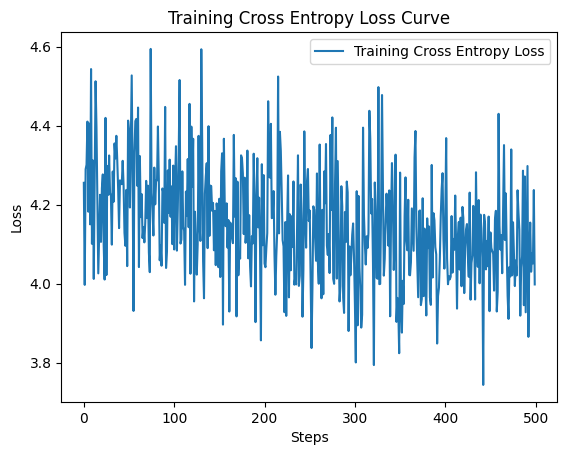

In [ ]:
train_loss_values = [x["loss"] for x in trainer.state.log_history[:-1]]

plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

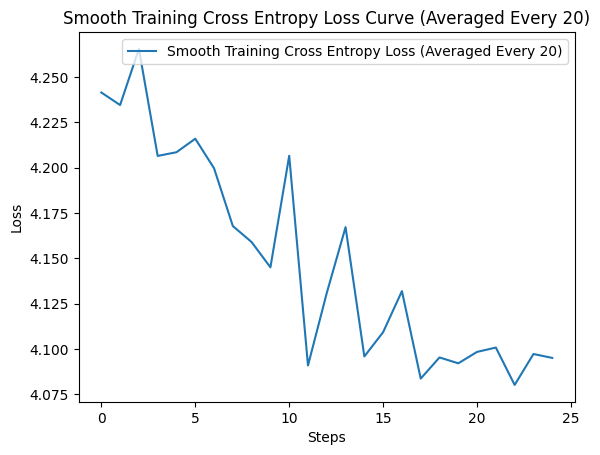

In [ ]:
smooth_train_cross_entropy_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

plt.plot(smooth_train_cross_entropy_loss_values, label="Smooth Training Cross Entropy Loss (Averaged Every 20)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Smooth Training Cross Entropy Loss Curve (Averaged Every 20)")
plt.legend()
plt.show()

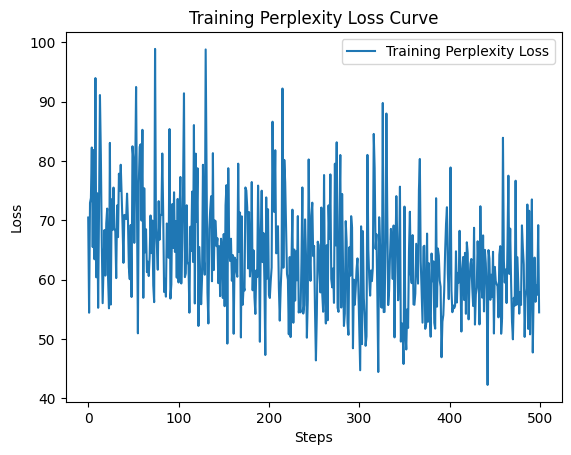

In [ ]:
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]

plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

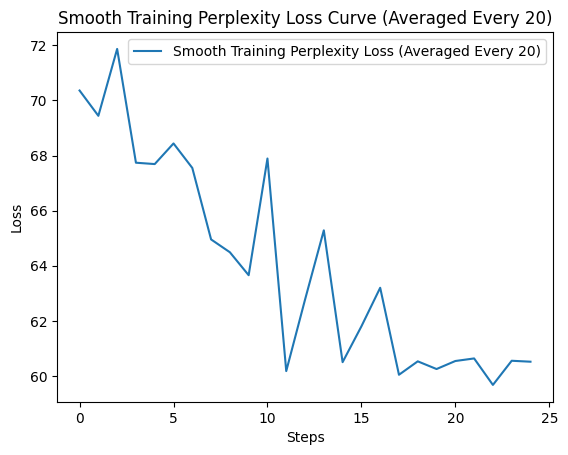

In [ ]:
smooth_train_perplexity_loss_values = [sum(perplexity_train_loss_values[i:i+20]) / 20 for i in range(0, len(perplexity_train_loss_values), 20)]

plt.plot(smooth_train_perplexity_loss_values, label="Smooth Training Perplexity Loss (Averaged Every 20)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Smooth Training Perplexity Loss Curve (Averaged Every 20)")
plt.legend()
plt.show()